In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


In [2]:
!pip uninstall -y scikit-learn sklearn imbalanced-learn
!pip install --no-cache-dir --force-reinstall \
  "scikit-learn==1.7.2" "imbalanced-learn==0.14.0" \
  "numpy==1.26.4" "scipy==1.13.0"

Found existing installation: scikit-learn 1.7.2
Uninstalling scikit-learn-1.7.2:
  Successfully uninstalled scikit-learn-1.7.2
Found existing installation: imbalanced-learn 0.14.0
Uninstalling imbalanced-learn-0.14.0:
  Successfully uninstalled imbalanced-learn-0.14.0


You can safely remove it manually.


   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------- 8.7/8.7 MB 77.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   ---------------------------------------- 15.5/15.5 MB 89.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/45.9 MB ? eta -:--:--
   --------------- ------------------------ 18.1/45.9 MB 94.8 MB/s eta 0:00:01
   ------------------------------ --------- 34.9/45.9 MB 88.5 MB/s eta 0:00:01
   ---------------------------------------- 45.9/45.9 MB 85.8 MB/s eta 0:00:00
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.6.0
    Uninstalling threadpoolctl-3.6.0:
      Successfully uninstalled threadpoolctl-3.6.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: joblib
    Found existing installation: job

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Discrete Modeling

## Data

In [3]:
binary_path = './binary_df.csv'
binary_df = pd.read_csv(binary_path, low_memory=False)

In [4]:
# 1) Split features/labels
X = binary_df.drop(columns=['sha256', 'type'])
y = binary_df['type']

X = X.astype('bool')
y = y.astype('bool')

Total features available: 22531
Top 20 features (for linear models): ['cspecifichandler', 'rtlvirtualunwind', 'rtllookupfunctionentry', 'fmode', 'rtlcapturecontext', 'iobfunc', 'free', 'malloc', 'amsgexit', 'cexit', 'rtladdfunctiontable', 'fprintf', 'unlock', 'lock', 'calloc', 'memcpy', 'libintlgettext', 'libintltextdomain', 'libintlbindtextdomain', 'abort']
All 22531 features (for tree-based models - they handle feature selection internally)
Top 25 features (for other models): ['cspecifichandler', 'rtlvirtualunwind', 'rtllookupfunctionentry', 'fmode', 'rtlcapturecontext', 'iobfunc', 'free', 'malloc', 'amsgexit', 'cexit', 'rtladdfunctiontable', 'fprintf', 'unlock', 'lock', 'calloc', 'memcpy', 'libintlgettext', 'libintltextdomain', 'libintlbindtextdomain', 'abort']... (showing first 20)


Starting Grid Search for all models...

=== Grid Search for LogReg ===
Using 20 features (linear model)
Starting grid search for LogReg...
Fitting 3 folds for each of 16 candidates, totalling 48 fits



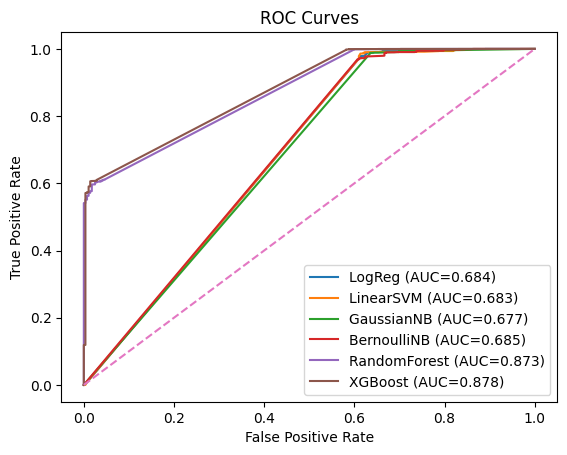

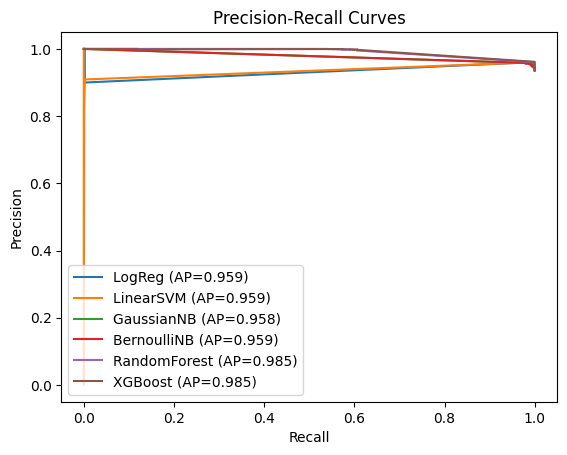

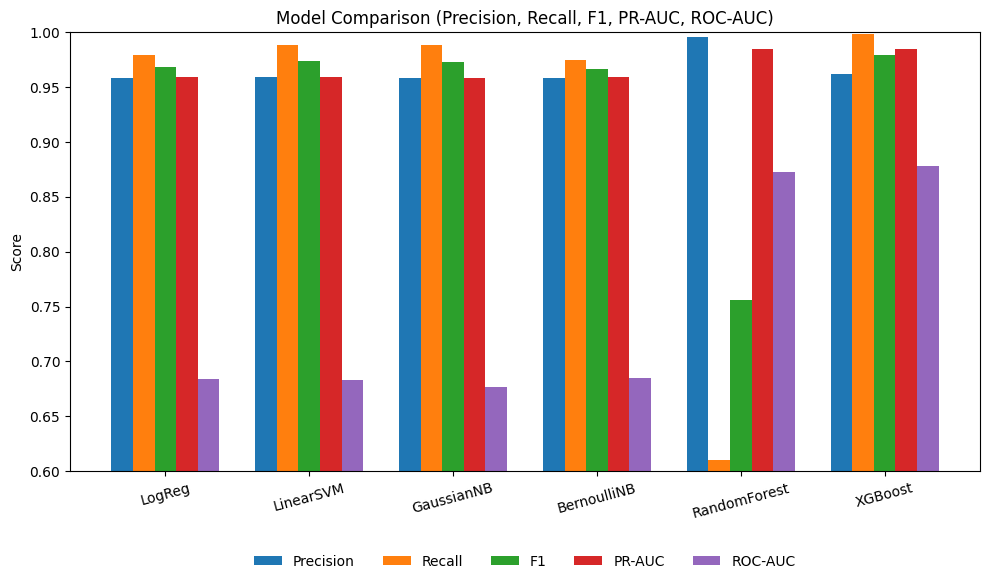

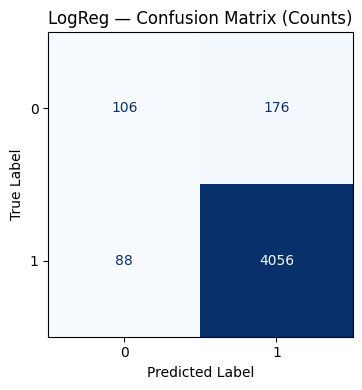

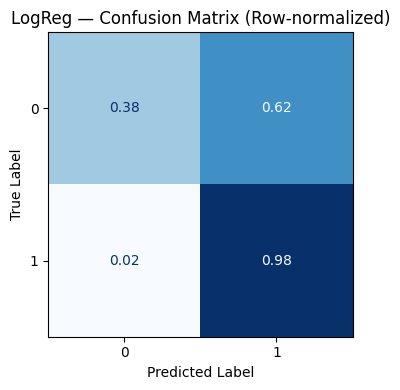

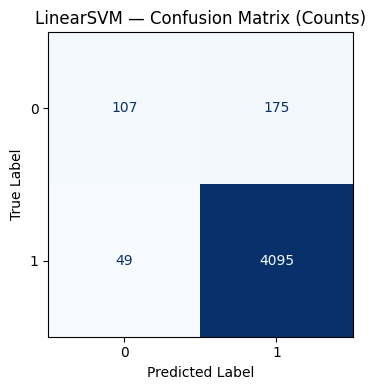

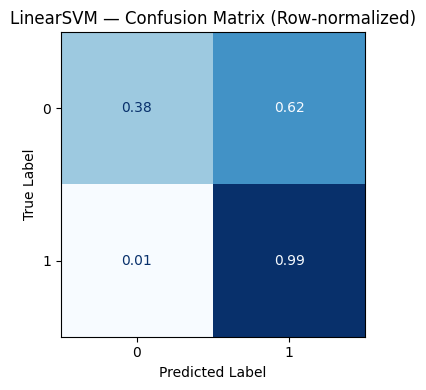

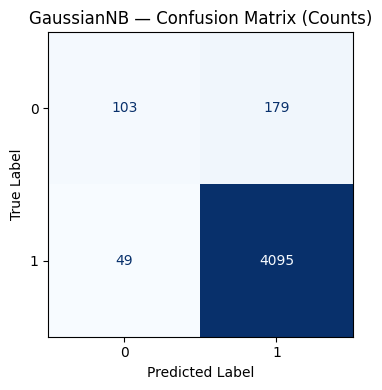

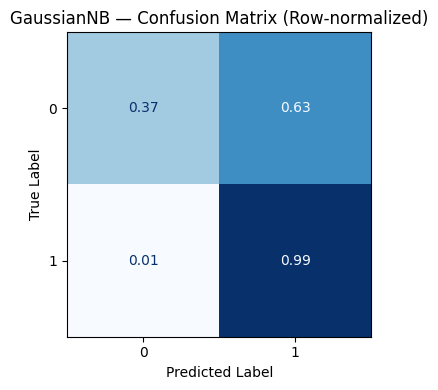

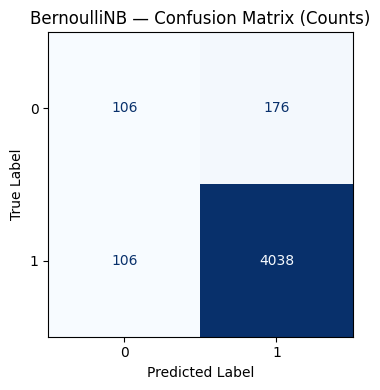

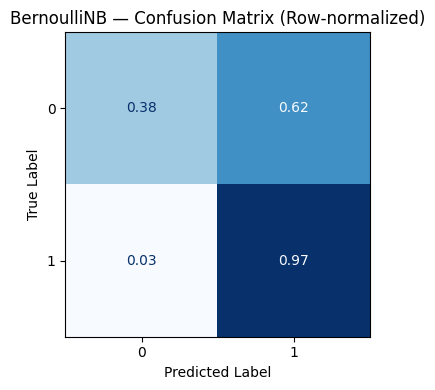

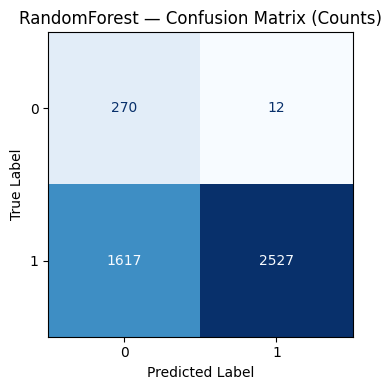

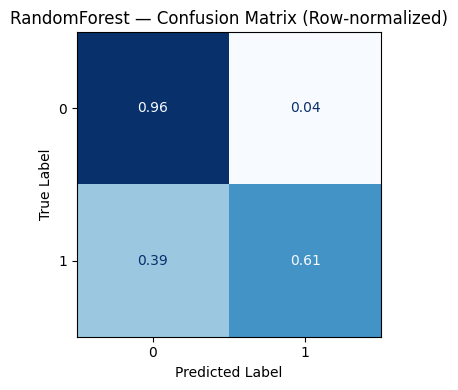

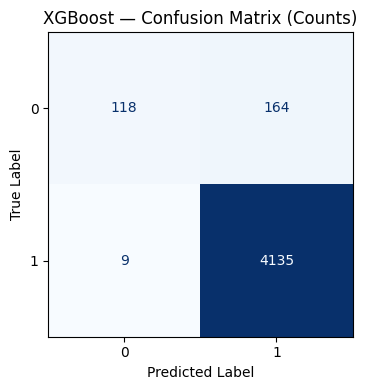

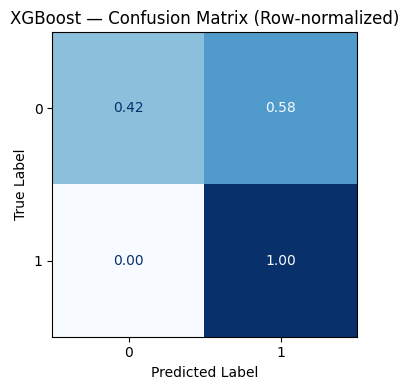


=== Model Results (Best from Grid Search) ===
Model        | PR-AUC   | ROC-AUC  | Accuracy | Precision | Recall  | F1     | Time (min)
----------------------------------------------------------------------------------------------------
LogReg       | 0.9591   | 0.6842   | 0.940    | 0.958     | 0.979   | 0.968  | 0.14      
LinearSVM    | 0.9587   | 0.6835   | 0.949    | 0.959     | 0.988   | 0.973  | 0.00      
GaussianNB   | 0.9579   | 0.6767   | 0.948    | 0.958     | 0.988   | 0.973  | 0.00      
BernoulliNB  | 0.9590   | 0.6845   | 0.936    | 0.958     | 0.974   | 0.966  | 0.00      
RandomForest | 0.9846   | 0.8729   | 0.632    | 0.995     | 0.610   | 0.756  | 3.38      
XGBoost      | 0.9847   | 0.8781   | 0.961    | 0.962     | 0.998   | 0.980  | 6.10      

Total training time: 577.30 seconds (9.62 minutes)


In [5]:
# ==== CORE SETUP (threads, imports) ===========================================
import os, multiprocessing
thread_count = multiprocessing.cpu_count()
os.environ['OPENBLAS_NUM_THREADS']=str(thread_count)
os.environ['MKL_NUM_THREADS']=str(thread_count)
os.environ['NUMEXPR_NUM_THREADS']=str(thread_count)
os.environ['OMP_NUM_THREADS']=str(thread_count)

import pandas as pd
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import (
    accuracy_score, precision_recall_curve, roc_curve, average_precision_score, roc_auc_score,
    precision_score, recall_score, f1_score, confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Optional XGBoost
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

# ==== UTILS ===================================================================
def to_csr(x):
    if sparse.issparse(x): return x.tocsr()
    if isinstance(x, pd.DataFrame): return sparse.csr_matrix(x.values)
    return sparse.csr_matrix(x)

class BinaryConstantDropper(BaseEstimator, TransformerMixin):
    """Drop all-zero or all-one binary columns without densifying."""
    def fit(self, X, y=None):
        X = to_csr(X); n = X.shape[0]
        sums = np.asarray(X.sum(axis=0)).ravel()
        self.keep_idx_ = np.where((sums != 0) & (sums != n))[0]
        return self
    def transform(self, X):
        X = to_csr(X)
        return X[:, self.keep_idx_]

def get_scores(est, X_test):
    # Use predict_proba if available; else decision_function; else predictions
    if hasattr(est, "predict_proba"):
        return est.predict_proba(X_test)[:, 1]
    elif hasattr(est, "decision_function"):
        return est.decision_function(X_test)
    else:
        return est.predict(X_test).astype(float)

def model_feature_importances(model):
    if hasattr(model, "feature_importances_"):
        imp = model.feature_importances_.ravel()
    elif hasattr(model, "coef_"):
        imp = np.abs(model.coef_).ravel()
    elif isinstance(model, BernoulliNB):
        imp = np.abs(model.feature_log_prob_[1] - model.feature_log_prob_[0]).ravel()
    elif isinstance(model, GaussianNB) and hasattr(model, "theta_") and hasattr(model, "sigma_"):
        imp = np.abs((model.theta_[1] - model.theta_[0]) / (np.sqrt(model.sigma_[0]) + 1e-9)).ravel()
    else:
        imp = None
    return imp

def to_dense(X):
    return X.toarray() if sparse.issparse(X) else X
Dense = FunctionTransformer(to_dense, accept_sparse=True)

# ==== DATA ====================================================================
df = pd.read_csv(binary_path, low_memory=False)
X_all = df.drop(columns=['sha256','type']).astype('uint8')
y_all = df['type']

# Select features using chi-square test (before train/test split)
# Different models will use different numbers of features
chi2_selector = SelectKBest(chi2, k='all')  # Get scores for all features
chi2_selector.fit(X_all, y_all)

# Get all features sorted by chi-square score
feature_scores = pd.Series(chi2_selector.scores_, index=X_all.columns)
all_features_sorted = feature_scores.sort_values(ascending=False).index.tolist()

# Define feature sets for different model types:
# - Linear models (LogReg, LinearSVM): fewer features (15-20) to prevent overfitting
# - Tree-based (RandomForest, XGBoost): ALL features - they have built-in feature selection
# - Other models: moderate set (20-30)

linear_features = all_features_sorted[:20]  # Top 20 for linear models
tree_features = all_features_sorted  # ALL features for tree-based models (they select internally)
moderate_features = all_features_sorted[:50]  # Top 50 for other models

print(f"Total features available: {len(X_all.columns)}")
print(f"Top 20 features (for linear models): {linear_features}")
print(f"All {len(tree_features)} features (for tree-based models - they handle feature selection internally)")
print(f"Top 25 features (for other models): {moderate_features[:20]}... (showing first 20)")
print("\n")

# Store feature sets for different model types
feature_sets = {
    'linear': linear_features,      # LogReg, LinearSVM
    'tree': tree_features,          # RandomForest, XGBoost - use all features
    'moderate': moderate_features    # GaussianNB, BernoulliNB
}

# For train/test split, use all available features (we'll subset per model later)
y = y_all
X_train_all, X_test_all, y_train, y_test = train_test_split(
    X_all, y, test_size=0.15, stratify=y, random_state=42
)

# ==== BASE PIPELINE ===========================================================
base_pipe = ImbPipeline(steps=[
    ('to_csr', FunctionTransformer(to_csr, accept_sparse=True)),
    ('constdrop', BinaryConstantDropper()),
    ('ros', RandomOverSampler(random_state=42)),
    ('clf', LogisticRegression())
])

# ==== GRID SEARCH PARAMETERS ==================================================
param_grids = {
    "LogReg": {
        'clf__C': [0.1, 10.0],
        'clf__penalty': ['l1', 'l2'],
        'clf__solver': ['saga'],
        'clf__max_iter': [3000],
        'clf__fit_intercept': [True, False],
        'ros__sampling_strategy': [0.33, 0.5]
        # Total: 2 * 2 * 2 * 2 * 2 = 32 combinations * 3 CV = 96 fits ✓
    },
    "LinearSVM": {
        'clf__C': [0.1, 10.0],
        'clf__tol': [1e-4, 1e-3],
        'clf__loss': ['hinge', 'squared_hinge'],
        'clf__max_iter': [3000],
        'ros__sampling_strategy': [0.33, 0.5]
        # Total: 2 * 2 * 2 * 2 * 2 = 32 combinations * 3 CV = 96 fits ✓
    },
    "GaussianNB": {
        'clf__var_smoothing': [1e-9, 1e-8, 1e-7],
        'ros__sampling_strategy': [0.33, 0.5]
        # Total: 3 * 2 = 6 combinations * 3 CV = 18 fits ✓
    },
    "BernoulliNB": {
        'clf__alpha': [0.1, 2.0],
        'clf__fit_prior': [True, False],
        'clf__binarize': [0.0, 0.5],
        'ros__sampling_strategy': [0.33, 0.5]
        # Total: 2 * 2 * 2 * 2 = 16 combinations * 3 CV = 48 fits ✓
    },
    "RandomForest": {
        'clf__n_estimators': [200, 500],
        'clf__max_depth': [10, 20],
        'clf__min_samples_split': [2, 5],
        'clf__min_samples_leaf': [1, 2],
        'clf__max_features': ['sqrt', 'log2'],
        'ros__sampling_strategy': [0.33, 0.5]
        # Total: 2 * 2 * 2 * 2 * 2 * 2 = 32 combinations * 3 CV = 96 fits ✓
    }
}

if HAS_XGB:
    param_grids["XGBoost"] = {
        'clf__n_estimators': [300, 600],
        'clf__learning_rate': [0.1, 0.2],
        'clf__max_depth': [4, 8],
        'clf__subsample': [0.8, 0.9],
        'clf__reg_lambda': [1.0, 2.0],
        'ros__sampling_strategy': [0.33, 0.5]
        # Total: 2 * 2 * 2 * 2 * 2 * 2 = 32 combinations * 3 CV = 96 fits ✓
    }

# ==== BASE ESTIMATORS =========================================================
base_estimators = {
    "LogReg": LogisticRegression(
        class_weight='balanced', n_jobs=-1, random_state=42
    ),
    "LinearSVM": LinearSVC(
        class_weight='balanced', dual='auto', random_state=42
    ),
    "GaussianNB": GaussianNB(),
    "BernoulliNB": BernoulliNB(),
    "RandomForest": RandomForestClassifier(
        class_weight='balanced_subsample', random_state=42, n_jobs=-1
    )
}
if HAS_XGB:
    base_estimators["XGBoost"] = XGBClassifier(
        n_jobs=-1, random_state=42, tree_method='hist',
        eval_metric='aucpr', scale_pos_weight=1.0
    )

# ==== GRID SEARCH + EVAL ======================================================
results = {}
roc_curves, pr_curves, fitted_pipes, cms = {}, {}, {}, {}
best_models = {}

print("Starting Grid Search for all models...\n")

for name, estimator in base_estimators.items():
    print(f"=== Grid Search for {name} ===")
    
    # Select appropriate feature set based on model type
    if name in ["LogReg", "LinearSVM"]:
        selected_features = feature_sets['linear']
        print(f"Using {len(selected_features)} features (linear model)")
    elif name in ["RandomForest", "XGBoost"]:
        selected_features = feature_sets['tree']
        print(f"Using {len(selected_features)} features (tree-based model)")
    else:
        selected_features = feature_sets['moderate']
        print(f"Using {len(selected_features)} features (other model)")
    
    # Subset features for this model
    X_train = X_train_all[selected_features]
    X_test = X_test_all[selected_features]
    
    # Create pipeline
    pipe = clone(base_pipe).set_params(clf=estimator)
    
    # Special handling for GaussianNB (needs dense features)
    if name == "GaussianNB":
        steps = pipe.steps[:-1] + [('todense', Dense)] + [('clf', estimator)]
        pipe = ImbPipeline(steps=steps)
    
    # Perform grid search with timing
    start_time = time.time()
    grid_search = GridSearchCV(
        pipe,
        param_grids[name],
        scoring='f1_macro',  # Using f1_macro to balance both classes
        cv=3,
        n_jobs=-1,  # Use all available cores
        verbose=2  # More verbose output for progress
    )
    
    print(f"Starting grid search for {name}...")
    grid_search.fit(X_train, y_train)
    elapsed_time = time.time() - start_time
    best_models[name] = grid_search.best_estimator_
    
    print(f"\nBest parameters for {name}: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    print(f"Training time: {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)\n")
    
    # Evaluate best model on test set
    fitted_pipes[name] = best_models[name]
    scores = get_scores(best_models[name], X_test)
    ap = average_precision_score(y_test, scores)
    roc_auc = roc_auc_score(y_test, scores)
    preds = (scores >= 0.5).astype(int)
    
    pr_prec, pr_rec, _ = precision_recall_curve(y_test, scores)
    fpr, tpr, _ = roc_curve(y_test, scores)
    pr_curves[name], roc_curves[name] = (pr_rec, pr_prec), (fpr, tpr)
    
    cm = confusion_matrix(y_test, preds, labels=[0,1])
    cms[name] = cm
    
    results[name] = {
        "PR_AUC": ap, "ROC_AUC": roc_auc,
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds, zero_division=0),
        "Recall": recall_score(y_test, preds, zero_division=0),
        "F1": f1_score(y_test, preds, zero_division=0),
        "Best_Params": grid_search.best_params_,
        "Training_Time": elapsed_time
    }
    
    # Print confusion matrix, classification report, and accuracy for best model
    print(f"\n--- {name} Best Model Results ---")
    print(f"PR_AUC: {results[name]["PR_AUC"]:.4f}")
    print(f"ROC_AUC: {results[name]["ROC_AUC"]:.4f}")
    print(f"Accuracy: {results[name]["Accuracy"]:.4f}")
    print(f"\nConfusion Matrix:")
    print(cm)
    print(f"\nClassification Report:")
    print(classification_report(y_test, preds, zero_division=0))
    print("="*80 + "\n")

# ==== PLOTS ===================================================================
# 1) ROC curves
plt.figure()
for name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC={results[name]["ROC_AUC"]:.3f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

# 2) PR curves
plt.figure()
for name, (rec, prec) in pr_curves.items():
    plt.plot(rec, prec, label=f'{name} (AP={results[name]["PR_AUC"]:.3f})')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# 3) Comparison bar chart: Precision, Recall, F1, PR-AUC, Accuracy
labels = list(results.keys())
precisions = [results[m]["Precision"] for m in labels]
recalls    = [results[m]["Recall"] for m in labels]
f1s        = [results[m]["F1"] for m in labels]
ap_scores  = [results[m]["PR_AUC"] for m in labels]
rocs = [results[m]["ROC_AUC"] for m in labels]

x = np.arange(len(labels))
w = 0.15  # slightly narrower bars so they fit

plt.figure(figsize=(10, 6))
plt.bar(x - 2*w, precisions, width=w, label='Precision')
plt.bar(x - w,   recalls,   width=w, label='Recall')
plt.bar(x,       f1s,       width=w, label='F1')
plt.bar(x + w,   ap_scores, width=w, label='PR-AUC')
plt.bar(x + 2*w, rocs, width=w, label='ROC-AUC')

plt.xticks(x, labels, rotation=15)
plt.ylim(0.6, 1.0)
plt.ylabel('Score')
plt.title('Model Comparison (Precision, Recall, F1, PR-AUC, ROC-AUC)')

# centered legend at bottom
plt.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, -0.25),
    ncol=5,          # one row, all five metrics
    frameon=False
)

plt.tight_layout()
plt.show()

# 4) Confusion Matrices — plotted separately for each model
from sklearn.metrics import ConfusionMatrixDisplay

for name, cm in cms.items():
    # ---- Raw counts ----
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    fig, ax = plt.subplots(figsize=(4, 4))
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    plt.title(f'{name} — Confusion Matrix (Counts)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    # ---- Row-normalized percentages ----
    with np.errstate(all='ignore'):
        cm_norm = cm / cm.sum(axis=1, keepdims=True)
        cm_norm = np.nan_to_num(cm_norm)
    disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=[0, 1])
    fig, ax = plt.subplots(figsize=(4, 4))
    disp_norm.plot(ax=ax, cmap='Blues', colorbar=False, values_format='.2f')
    plt.title(f'{name} — Confusion Matrix (Row-normalized)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

# ==== PRINT SUMMARY TABLE =====================================================
print("\n=== Model Results (Best from Grid Search) ===")
print(f"{'Model':<12} | {'PR-AUC':<8} | {'ROC-AUC':<8} | {'Accuracy':<8} | {'Precision':<9} | {'Recall':<7} | {'F1':<6} | {'Time (min)':<10}")
print("-" * 100)
for name, mets in results.items():
    print(
        f"{name:<12} | "
        f"{mets['PR_AUC']:<8.4f} | "
        f"{mets['ROC_AUC']:<8.4f} | "
        f"{mets['Accuracy']:<8.3f} | "
        f"{mets['Precision']:<9.3f} | "
        f"{mets['Recall']:<7.3f} | "
        f"{mets['F1']:<6.3f} | "
        f"{mets['Training_Time']/60:<10.2f}"
    )

# Print total time
total_time = sum(mets['Training_Time'] for mets in results.values())
print(f"\nTotal training time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")


In [6]:
# from sklearn.feature_selection import SelectKBest, chi2
# from sklearn.metrics import roc_auc_score

# for k in [500, 1000, 2000, 5000, 10000, X_train.shape[1]]:
#     chi = SelectKBest(chi2, k=k)
#     Xtr = chi.fit_transform(X_train, y_train)
#     Xte = chi.transform(X_test)
#     clf = LogisticRegression(max_iter=2000, class_weight='balanced')
#     clf.fit(Xtr, y_train)
#     print(f"k={k:5d}, ROC-AUC={roc_auc_score(y_test, clf.predict_proba(Xte)[:,1]):.3f}")
